In [4]:
import tensorflow as tf
from tensorflow import feature_column as fc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
df = pd.read_csv('plant_growth_data.csv')

# Splitting the dataset into training (80%), validation (10%), and test (10%) sets
train, test = train_test_split(df, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)

# Convert the training dataset from DataFrame into Dataset object
def df_to_dataset(dataframe, shuffle=True, batch_size=8):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Growth_Milestone')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

# Numerical columns with MinMax scaling
def minmax_scaling(col):
    min_val = np.min(col)
    max_val = np.max(col)
    return (col - min_val) / (max_val - min_val)

train['Sunlight_Hours'] = minmax_scaling(train['Sunlight_Hours'])
train['Temperature'] = minmax_scaling(train['Temperature'])
train['Humidity'] = minmax_scaling(train['Humidity'])

sunlight_hours = fc.numeric_column('Sunlight_Hours')
temperature = fc.numeric_column('Temperature')
humidity = fc.numeric_column('Humidity')

# Categorical columns with one hot encoding
soil_type = fc.categorical_column_with_vocabulary_list('Soil_Type', train['Soil_Type'].unique())
fertilizer_type = fc.categorical_column_with_vocabulary_list('Fertilizer_Type', train['Fertilizer_Type'].unique())

soil_type_one_hot = fc.indicator_column(soil_type)
fertilizer_type_one_hot = fc.indicator_column(fertilizer_type)

# Bucketizing numerical columns
temperature_buckets = fc.bucketized_column(temperature, boundaries=[10, 20, 30, 40])
humidity_buckets = fc.bucketized_column(humidity, boundaries=[10, 20, 30, 40, 50, 60])

# Feature columns list
feature_columns = [sunlight_hours, temperature, humidity, soil_type_one_hot, fertilizer_type_one_hot, temperature_buckets, humidity_buckets]

# Feature cross
crossed_feature = fc.crossed_column([soil_type, fertilizer_type], hash_bucket_size=1000)
crossed_feature_one_hot = fc.indicator_column(crossed_feature)
feature_columns.append(crossed_feature_one_hot)

# Creating the model
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
20/20 [==============================] - 2s 19ms/step - loss: 0.8882 - accuracy: 0.4516 - val_loss: 0.6990 - val_accuracy: 0.5556
Epoch 2/10
20/20 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5548 - val_loss: 0.6781 - val_accuracy: 0.5556
Epoch 3/10
20/20 [==============================] - 0s 8ms/step - loss: 0.6647 - accuracy: 0.6258 - val_loss: 0.6916 - val_accuracy: 0.5556
Epoch 4/10
20/20 [==============================] - 0s 5ms/step - loss: 0.7349 - accuracy: 0.5161 - val_loss: 0.7338 - val_accuracy: 0.5556
Epoch 5/10
20/20 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.6129 - val_loss: 0.7305 - val_accuracy: 0.5556
Epoch 6/10
20/20 [==============================] - 0s 5ms/step - loss: 0.6328 - accuracy: 0.6194 - val_loss: 0.6660 - val_accuracy: 0.6111
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.6449 - accuracy: 0.6258 - val_loss: 0.6754 - val_accuracy: 0.6111
Epoch 8/10
20/20 [=

3/3 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.6000


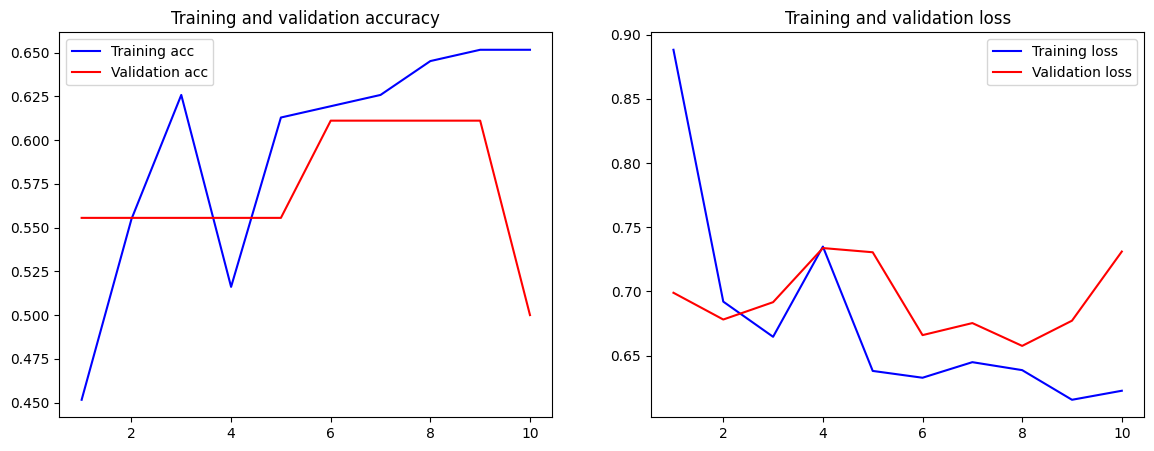

In [5]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_ds)

# Plotting training and validation error
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
